<a href="https://colab.research.google.com/github/StefTse/AIDL_xrcises/blob/main/intent_classification_AIDL_B_CS01_0035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment for AIDL_B_C021 (NLP): Intent Classification for Q&As
####Stefanos_Tsemperlidis_0035

1. Preprocessing

In [1]:
#Import modules and data
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

data=pd.read_csv('/content/cs01_dataset.csv')

print(data.columns)
print('')
print(data.shape)
print(data.head())
print('')
data.dtypes

Index(['ID', 'Question', 'Intent'], dtype='object')

(4482, 3)
         ID                                         Question      Intent
0  000_0018                          Is there a parking lot?  Irrelevant
1  001_0018                            Is this program easy?  Irrelevant
2  002_0018                 Do most students pass the exams?  Irrelevant
3  003_0018        How many students are currently enrolled?  Irrelevant
4  004_0018  Are there any buses from university to Piraeus?  Irrelevant



ID          object
Question    object
Intent      object
dtype: object

In [2]:
#Remove "ID"
data_01=data[["Question",'Intent']]
data_01.head()

,Question,Intent
0,Is there a parking lot?,Irrelevant
1,Is this program easy?,Irrelevant
2,Do most students pass the exams?,Irrelevant
3,How many students are currently enrolled?,Irrelevant
4,Are there any buses from university to Piraeus?,Irrelevant


In [3]:
data_01.isnull().sum()

Question    0
Intent      0
dtype: int64

In [4]:
#Remove duplicates
data_02=data_01.drop_duplicates(subset=['Question'])
data_02.shape

(4403, 2)

In [5]:
#Check instances 
print('Instances per intent')
print(data_02['Intent'].value_counts())
x=data_02['Intent'].value_counts()
y=(x/4403)*100
print('')
print('Intent percentage (%)')
print(round(y,0))

Instances per intent
Instructors     571
Curriculum      529
Irrelevant      445
Applications    440
Schedule        437
Documents       430
Contact         424
Fees            397
Invited         365
Registry        365
Name: Intent, dtype: int64

Intent percentage (%)
Instructors     13.0
Curriculum      12.0
Irrelevant      10.0
Applications    10.0
Schedule        10.0
Documents       10.0
Contact         10.0
Fees             9.0
Invited          8.0
Registry         8.0
Name: Intent, dtype: float64


In [6]:
data_02.head()

,Question,Intent
0,Is there a parking lot?,Irrelevant
1,Is this program easy?,Irrelevant
2,Do most students pass the exams?,Irrelevant
3,How many students are currently enrolled?,Irrelevant
4,Are there any buses from university to Piraeus?,Irrelevant


In [7]:
# Replacing intent text values to numerical 
data_03=data_02.replace({"Instructors":0,"Curriculum":1,"Irrelevant":2, "Applications":3, "Schedule":4, 
                         "Documents":5, "Contact":6, "Fees":7, "Invited":8, "Registry":9 })
data_03.head()

,Question,Intent
0,Is there a parking lot?,2
1,Is this program easy?,2
2,Do most students pass the exams?,2
3,How many students are currently enrolled?,2
4,Are there any buses from university to Piraeus?,2


In [8]:
# train, validation and test split dataset
x_train, x_test, y_train, y_test = train_test_split(data_03["Question"], data_03["Intent"], test_size = 0.1, shuffle=True, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True, random_state = 1) 


In [9]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((3565,), (397,), (441,), (3565,), (397,), (441,))

In [10]:
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
print(stopwords.words('english'))
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
def preprocess(text):
  text = nltk.word_tokenize(text.lower()) #lower case
  text = [w for w in text if not w in stop_words]
  text = (" ").join(text)
  text = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", text)
  text = re.sub(r"\s+", r" ", text).strip()
  text = re.sub(r'[^\w\s]', '', text)
  
  return text

x_train = x_train.apply(preprocess)
x_val =x_val.apply(preprocess)
x_test = x_test.apply(preprocess)

x_train.head()

164      send spring semester schedule 
3048                            hunrgy 
3812       tell papageorgas panagiotis 
2311    find list classes m registered 
3783                   excused tuition 
Name: Question, dtype: object

In [12]:
word_to_counts = Counter(x_train)
word_to_counts


Counter({'send spring semester schedule ': 1,
         'hunrgy ': 1,
         'tell papageorgas panagiotis ': 1,
         'find list classes m registered ': 1,
         'excused tuition ': 1,
         'rearrange interview date': 1,
         'may call info ': 1,
         'want information week scheduling ': 1,
         'buses university piraeus ': 1,
         'phone number mr patrikakis ': 1,
         'applicants invitation': 1,
         'd like see list instructors ': 1,
         'get application course modification ': 1,
         'courses minor autonomous system include ': 1,
         'astrological sign ': 1,
         'courses professor papadopoulos teaching ': 1,
         'email address mr kasnesis ': 1,
         'non eu national need pay ': 1,
         'read tuition fees regulations ': 1,
         'email adress mr kasnesis ': 1,
         'check grades ': 1,
         'see exams dates': 1,
         'courses professor ganetsos teaching ': 1,
         'contact details': 1,
         'lon

In [13]:
# Get the number of unique words in the text data
n_words = len(word_to_counts)
n_words

3457

In [14]:

#create a word-to-index dictionary
tokenizer = Tokenizer(num_words=n_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

#convert the text data to numerical data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [15]:
#Pad the sequences to have the same length
max_length = max([len(s) for s in x_train_seq + x_val_seq + x_test_seq])
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length)


In [16]:
x_train_pad.shape

(3565, 13)

In [17]:
#Define the number of unique classes
n_classes = len(np.unique(y_train))
n_classes

10

In [18]:
# Convert the class labels to one-hot encoded vectors
y_train_enc = tf.keras.utils.to_categorical(y_train, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test, n_classes)

In [19]:
y_train_enc.shape

(3565, 10)

2. LSTM without pre-trained embeddings

In [20]:
# Define the LSTM model
model_01 = Sequential()
model_01.add(Embedding(input_dim=n_words, output_dim=64, input_length=max_length))
model_01.add(LSTM(64))
model_01.add(Dropout(0.5))
model_01.add(Dense(n_classes, activation='softmax'))
model_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 64)            221248    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 254,922
Trainable params: 254,922
Non-trainable params: 0
_________________________________________________________________


In [21]:
 # Compile and fit the model
model_01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_01.fit(x_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(x_val_pad, y_val_enc))

Epoch 1/10
112/112 [==============================] - 8s 9ms/step - loss: 2.2210 - accuracy: 0.1860 - val_loss: 1.9035 - val_accuracy: 0.4055
Epoch 2/10
112/112 [==============================] - 1s 5ms/step - loss: 1.1993 - accuracy: 0.6264 - val_loss: 0.8151 - val_accuracy: 0.7783
Epoch 3/10
112/112 [==============================] - 1s 5ms/step - loss: 0.6433 - accuracy: 0.8045 - val_loss: 0.5894 - val_accuracy: 0.8237
Epoch 4/10
112/112 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.8886 - val_loss: 0.5623 - val_accuracy: 0.8287
Epoch 5/10
112/112 [==============================] - 1s 5ms/step - loss: 0.2924 - accuracy: 0.9215 - val_loss: 0.5623 - val_accuracy: 0.8363
Epoch 6/10
112/112 [==============================] - 1s 5ms/step - loss: 0.2351 - accuracy: 0.9422 - val_loss: 0.5390 - val_accuracy: 0.8312
Epoch 7/10
112/112 [==============================] - 1s 5ms/step - loss: 0.1951 - accuracy: 0.9450 - val_loss: 0.5081 - val_accuracy: 0.8539
Epoch 

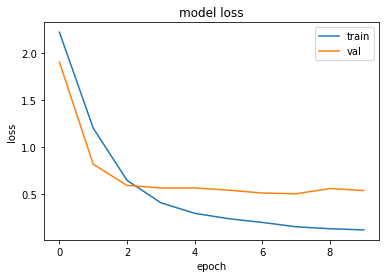

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

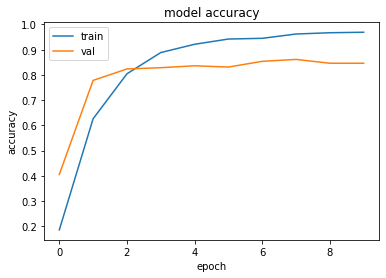

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
 # Evaluate the model on the test data
score, acc = model_01.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 3ms/step - loss: 0.5818 - accuracy: 0.8481
Test score: 0.5818343758583069
Test accuracy: 0.8480725884437561


In [25]:
# Generate the classification report
y_pred = model_01.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        64
           1       0.85      0.76      0.80        59
           2       0.72      0.76      0.74        45
           3       0.78      0.85      0.81        41
           4       0.77      0.92      0.84        26
           5       0.75      0.85      0.80        47
           6       0.85      0.89      0.87        37
           7       0.97      0.97      0.97        40
           8       0.93      0.90      0.92        42
           9       1.00      0.62      0.77        40

    accuracy                           0.85       441
   macro avg       0.85      0.85      0.85       441
weighted avg       0.86      0.85      0.85       441



<Figure size 720x720 with 0 Axes>

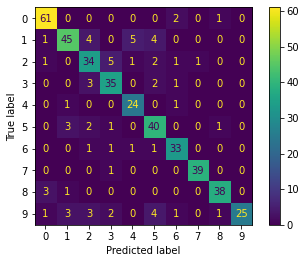

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

In [27]:
# Define LSTM model_02
from keras.layers import Flatten

model_02 = Sequential()
model_02.add(Embedding(input_dim=n_words, output_dim=64, input_length=max_length))
model_02.add(LSTM(64,return_sequences=True))
model_02.add(Dropout(0.5))
model_02.add(LSTM(64, return_sequences=True))
model_02.add(Dropout(0.5))
model_02.add(Flatten())
model_02.add(Dense(n_classes, activation='softmax'))
model_02.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 13, 64)            221248    
                                                                 
 lstm_1 (LSTM)               (None, 13, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 13, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 13, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 13, 64)            0         
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [28]:
# Compile and fit the model
model_02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_02.fit(x_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(x_val_pad, y_val_enc))

Epoch 1/10
112/112 [==============================] - 4s 12ms/step - loss: 2.2820 - accuracy: 0.1417 - val_loss: 2.1624 - val_accuracy: 0.1814
Epoch 2/10
112/112 [==============================] - 1s 6ms/step - loss: 1.7912 - accuracy: 0.3108 - val_loss: 1.4314 - val_accuracy: 0.4509
Epoch 3/10
112/112 [==============================] - 1s 6ms/step - loss: 1.1616 - accuracy: 0.5728 - val_loss: 1.0026 - val_accuracy: 0.6549
Epoch 4/10
112/112 [==============================] - 1s 7ms/step - loss: 0.7929 - accuracy: 0.7388 - val_loss: 0.8060 - val_accuracy: 0.7380
Epoch 5/10
112/112 [==============================] - 1s 7ms/step - loss: 0.5862 - accuracy: 0.8174 - val_loss: 0.7313 - val_accuracy: 0.7783
Epoch 6/10
112/112 [==============================] - 1s 6ms/step - loss: 0.4452 - accuracy: 0.8704 - val_loss: 0.6763 - val_accuracy: 0.7960
Epoch 7/10
112/112 [==============================] - 1s 6ms/step - loss: 0.3622 - accuracy: 0.8937 - val_loss: 0.6435 - val_accuracy: 0.8237
Epoch

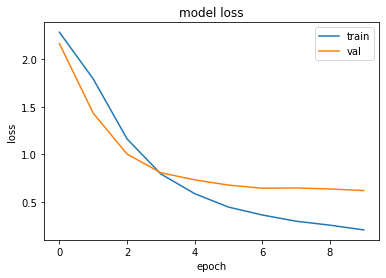

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

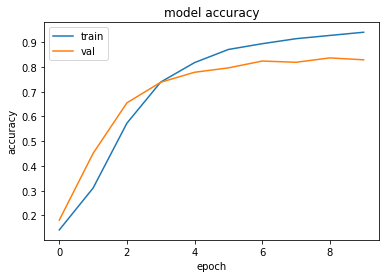

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
# Evaluate the model on the test data
score, acc = model_02.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 3ms/step - loss: 0.7500 - accuracy: 0.8095
Test score: 0.7500162124633789
Test accuracy: 0.8095238208770752


In [32]:
# Generate the classification report
y_pred = model_02.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

14/14 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        64
           1       0.71      0.88      0.79        59
           2       0.88      0.47      0.61        45
           3       0.65      0.83      0.73        41
           4       0.68      0.88      0.77        26
           5       0.85      0.72      0.78        47
           6       0.82      0.84      0.83        37
           7       0.91      1.00      0.95        40
           8       0.93      0.88      0.90        42
           9       0.82      0.57      0.68        40

    accuracy                           0.81       441
   macro avg       0.82      0.80      0.80       441
weighted avg       0.82      0.81      0.80       441



<Figure size 720x720 with 0 Axes>

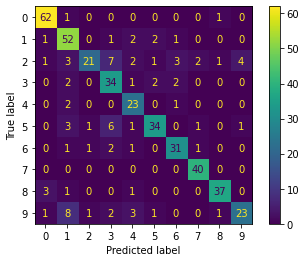

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

3. LSTM with Glove pre-trained word embeddings.

> Indented block



In [34]:
#Download Glove word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2023-02-06 11:23:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-06 11:23:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-06 11:23:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [35]:
#!unzip /content/glove.6B.zip.1

In [36]:
#Create a dictionary with Glove embeddings
embeddings_index = {}
with open("/content/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [37]:
#Create embedding matrix. Words not found in embedding index will be all-zeros.
embedding_matrix = np.zeros((n_words, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [38]:
#first LSTM model
model_03 = Sequential()
model_03.add(Embedding(input_dim=n_words, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_03.add(LSTM(64))
model_03.add(Dropout(0.5))
model_03.add(Dense(n_classes, activation='softmax'))
model_03.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 13, 100)           345700    
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 388,590
Trainable params: 42,890
Non-trainable params: 345,700
_________________________________________________________________


In [39]:
# Compile and fit the model
model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_03.fit(x_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(x_val_pad, y_val_enc))

Epoch 1/10
112/112 [==============================] - 3s 8ms/step - loss: 1.7955 - accuracy: 0.4384 - val_loss: 1.1666 - val_accuracy: 0.6776
Epoch 2/10
112/112 [==============================] - 0s 4ms/step - loss: 1.0992 - accuracy: 0.6586 - val_loss: 0.8830 - val_accuracy: 0.7557
Epoch 3/10
112/112 [==============================] - 0s 4ms/step - loss: 0.8917 - accuracy: 0.7302 - val_loss: 0.7965 - val_accuracy: 0.7531
Epoch 4/10
112/112 [==============================] - 0s 4ms/step - loss: 0.7793 - accuracy: 0.7498 - val_loss: 0.7361 - val_accuracy: 0.7733
Epoch 5/10
112/112 [==============================] - 1s 5ms/step - loss: 0.7169 - accuracy: 0.7770 - val_loss: 0.7344 - val_accuracy: 0.7582
Epoch 6/10
112/112 [==============================] - 0s 4ms/step - loss: 0.6605 - accuracy: 0.7941 - val_loss: 0.6656 - val_accuracy: 0.7859
Epoch 7/10
112/112 [==============================] - 0s 4ms/step - loss: 0.6244 - accuracy: 0.8084 - val_loss: 0.6730 - val_accuracy: 0.7834
Epoch 

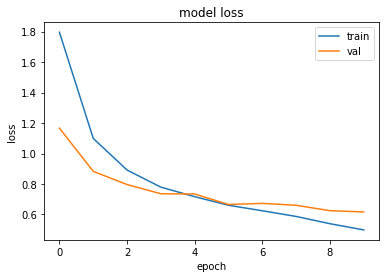

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

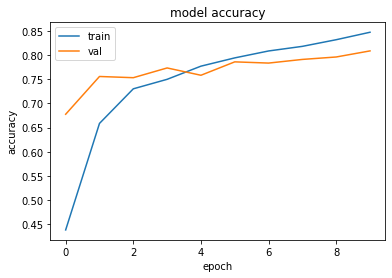

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
 # Evaluate the model on the test data
score, acc = model_03.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.8095
Test score: 0.6306983232498169
Test accuracy: 0.8095238208770752


In [43]:
# Generate the classification report
y_pred = model_03.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        64
           1       0.76      0.81      0.79        59
           2       0.76      0.64      0.70        45
           3       0.69      0.90      0.78        41
           4       0.83      0.92      0.87        26
           5       0.85      0.72      0.78        47
           6       0.81      0.78      0.79        37
           7       0.95      0.93      0.94        40
           8       0.89      0.81      0.85        42
           9       0.90      0.68      0.77        40

    accuracy                           0.81       441
   macro avg       0.82      0.81      0.81       441
weighted avg       0.82      0.81      0.81       441



<Figure size 720x720 with 0 Axes>

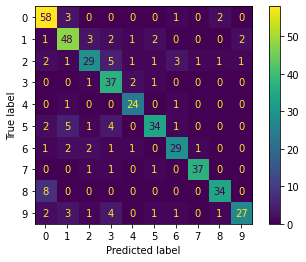

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

In [45]:
# Define the LSTM model_02
model_04 = Sequential()
model_04.add(Embedding(input_dim=n_words, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False,input_shape=(max_length,)))
model_04.add(LSTM(64,return_sequences=True))
model_04.add(Dropout(0.5))
model_04.add(LSTM(64, return_sequences=True))
model_04.add(Dropout(0.5))
model_04.add(Flatten())
model_04.add(Dense(n_classes, activation='softmax'))
model_04.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 13, 100)           345700    
                                                                 
 lstm_4 (LSTM)               (None, 13, 64)            42240     
                                                                 
 dropout_4 (Dropout)         (None, 13, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 13, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 13, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 832)               0         
                                                                 
 dense_3 (Dense)             (None, 10)               

In [46]:
# Compile and fit the model
model_04.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_04.fit(x_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(x_val_pad, y_val_enc))

Epoch 1/10
112/112 [==============================] - 4s 12ms/step - loss: 1.9845 - accuracy: 0.3344 - val_loss: 1.4559 - val_accuracy: 0.5365
Epoch 2/10
112/112 [==============================] - 1s 6ms/step - loss: 1.3133 - accuracy: 0.5630 - val_loss: 1.0697 - val_accuracy: 0.6574
Epoch 3/10
112/112 [==============================] - 1s 6ms/step - loss: 1.0659 - accuracy: 0.6432 - val_loss: 0.9704 - val_accuracy: 0.6826
Epoch 4/10
112/112 [==============================] - 1s 6ms/step - loss: 0.9364 - accuracy: 0.6954 - val_loss: 0.8807 - val_accuracy: 0.7330
Epoch 5/10
112/112 [==============================] - 1s 7ms/step - loss: 0.8262 - accuracy: 0.7279 - val_loss: 0.8031 - val_accuracy: 0.7531
Epoch 6/10
112/112 [==============================] - 1s 7ms/step - loss: 0.7534 - accuracy: 0.7560 - val_loss: 0.7903 - val_accuracy: 0.7355
Epoch 7/10
112/112 [==============================] - 1s 7ms/step - loss: 0.6990 - accuracy: 0.7700 - val_loss: 0.7114 - val_accuracy: 0.7809
Epoch

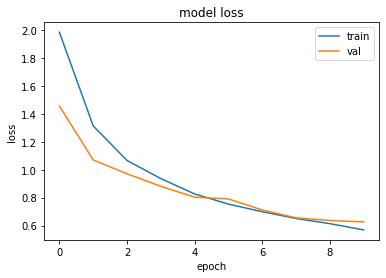

In [47]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

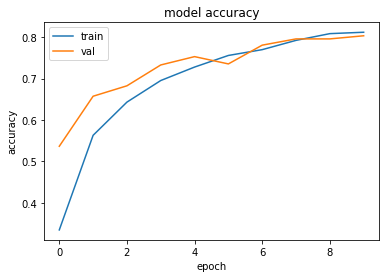

In [48]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
 # Evaluate the model on the test data
score, acc = model_04.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

14/14 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.7755
Test score: 0.6261365413665771
Test accuracy: 0.7755101919174194


In [50]:
# Generate the classification report
y_pred = model_04.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

14/14 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        64
           1       0.78      0.73      0.75        59
           2       0.58      0.71      0.64        45
           3       0.61      0.76      0.67        41
           4       0.77      0.88      0.82        26
           5       0.84      0.66      0.74        47
           6       0.83      0.81      0.82        37
           7       0.97      0.88      0.92        40
           8       0.87      0.81      0.84        42
           9       0.78      0.70      0.74        40

    accuracy                           0.78       441
   macro avg       0.79      0.78      0.78       441
weighted avg       0.79      0.78      0.78       441



<Figure size 720x720 with 0 Axes>

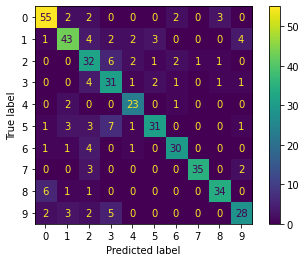

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

4. Transformers

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.8 MB/s eta 0:00:00


###BERT


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
# train, validation and test split dataset
x_train, x_test, y_train, y_test = train_test_split(data_03["Question"], data_03["Intent"], test_size = 0.1, shuffle=True, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True, random_state = 1) 


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((3565,), (3565,), (441,), (441,), (397,), (397,))

In [ ]:
#tokenize and pad
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#x_train_pad = tokenizer.batch_encode_plus(x_train, return_tensors='tf', padding='longest')
#x_val_pad = tokenizer.batch_encode_plus(x_val, return_tensors='tf', padding='longest')
#x_test_pad = tokenizer.batch_encode_plus(x_test, return_tensors='tf', padding='longest')

In [ ]:
#tokenize and pad
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

x_train_pad = tokenizer.batch_encode_plus(x_train, return_tensors='tf', padding='max_length')
x_val_pad = tokenizer.batch_encode_plus(x_val, return_tensors='tf', padding='max_length')
x_test_pad = tokenizer.batch_encode_plus(x_test, return_tensors='tf', padding='max_length')

In [ ]:
#convert input to numpy array
x_train_np = x_train_pad['input_ids'].numpy()
x_val_np = x_val_pad['input_ids'].numpy()
x_test_np = x_test_pad['input_ids'].numpy()

In [ ]:
x_train_np.shape, x_val_np.shape, x_test_np.shape

((3565, 512), (397, 512), (441, 512))

In [ ]:
#one-hot-encoding of classes
n_classes = len(np.unique(y_train))
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np=y_test.values

y_train_enc = tf.keras.utils.to_categorical(y_train_np, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val_np, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test_np, n_classes)

In [ ]:
y_train_enc.shape, y_val_enc.shape, y_test_enc

((3565, 10), (397, 10), array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [ ]:
#create BERT model
model_BERT = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
model_BERT.summary()


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_44 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 109,489,930
Trainable params: 109,489,930
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001)]
model_BERT.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
#compile model
#optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
#loss = tf.keras.losses.CategoricalCrossentropy()
#metric = tf.keras.metrics.CategoricalAccuracy()
#model_BERT.compile(optimizer=optimizer, loss=loss, metrics=metric)


In [ ]:
# train model with callbacks. Have tried epochs=3,10,20,50. Always underperformance.

history = model_BERT.fit(x_train_np, y_train_enc, batch_size=16, epochs=80, validation_data=(x_val_np, y_val_enc), callbacks=[keras_callbacks])



Epoch 1/80
223/223 [==============================] - 75s 254ms/step - loss: 7.9967 - categorical_accuracy: 0.0971 - val_loss: 8.7289 - val_categorical_accuracy: 0.0579
Epoch 2/80
223/223 [==============================] - 54s 243ms/step - loss: 7.9863 - categorical_accuracy: 0.1094 - val_loss: 8.7289 - val_categorical_accuracy: 0.1008
Epoch 3/80
223/223 [==============================] - 54s 243ms/step - loss: 8.1703 - categorical_accuracy: 0.1083 - val_loss: 7.3892 - val_categorical_accuracy: 0.0856
Epoch 4/80
223/223 [==============================] - 54s 243ms/step - loss: 8.0297 - categorical_accuracy: 0.1013 - val_loss: 8.7289 - val_categorical_accuracy: 0.1008
Epoch 5/80
223/223 [==============================] - 54s 242ms/step - loss: 8.0660 - categorical_accuracy: 0.1010 - val_loss: 7.3892 - val_categorical_accuracy: 0.1209
Epoch 6/80
223/223 [==============================] - 54s 242ms/step - loss: 8.4053 - categorical_accuracy: 0.1027 - val_loss: 8.7289 - val_categorical_acc

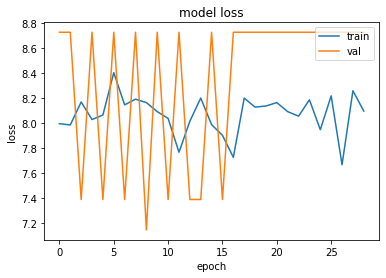

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


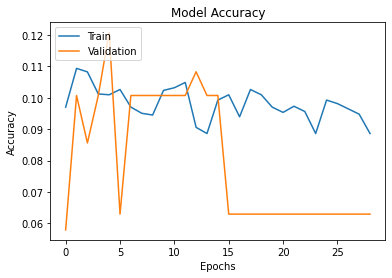

In [ ]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the model on the test data
score, acc = model_BERT.evaluate(x_test_np, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

14/14 [==============================] - 2s 145ms/step - loss: 7.6387 - categorical_accuracy: 0.0952
Test score: 7.638734340667725
Test accuracy: 0.095238097012043


In [ ]:
y_pred = model_BERT.predict(x_test_np)
y_pred

14/14 [==============================] - 5s 143ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 1.1711407, -1.3075632,  1.2750517, ...,  1.2695129,  1.2840593,
        -1.1506729],
       [ 1.1811925, -1.3144385,  1.2743515, ...,  1.2667868,  1.2862766,
        -1.1514854],
       [ 1.1805377, -1.314057 ,  1.2774582, ...,  1.2709726,  1.2871885,
        -1.1537346],
       ...,
       [ 1.1716444, -1.3076509,  1.2700534, ...,  1.2649838,  1.279373 ,
        -1.1505703],
       [ 1.1819997, -1.316481 ,  1.2736799, ...,  1.2664819,  1.2876173,
        -1.1513398],
       [ 1.189234 , -1.3232453,  1.2720195, ...,  1.2629328,  1.2877371,
        -1.152188 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
#Classification report
y_pred = model_BERT.predict(x_test_np)
y_pred = y_pred.logits # Extract the logits from the TFSequenceClassifierOutput object
y_pred = tf.nn.softmax(y_pred) # Convert the logits to probabilities
y_pred_class = tf.argmax(y_pred, axis=1) # Get the class index with the highest probability for each sample
print(classification_report(y_test_np, y_pred_class.numpy()))


14/14 [==============================] - 2s 142ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00        59
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00        41
           4       0.00      0.00      0.00        26
           5       0.00      0.00      0.00        47
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        40
           8       0.10      1.00      0.17        42
           9       0.00      0.00      0.00        40

    accuracy                           0.10       441
   macro avg       0.01      0.10      0.02       441
weighted avg       0.01      0.10      0.02       441



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 720x720 with 0 Axes>

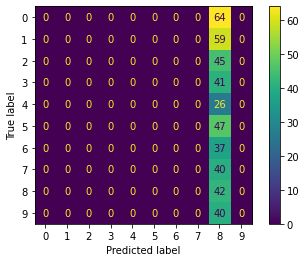

In [ ]:
conf_matrix = confusion_matrix(y_test_np, y_pred_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

###ROBERTa

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification


In [ ]:
# train, validation and test split dataset
x_train, x_test, y_train, y_test = train_test_split(data_03["Question"], data_03["Intent"], test_size = 0.1, shuffle=True, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True, random_state = 1) 


In [ ]:
#Tokenize and pad data
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
x_train_pad = tokenizer.batch_encode_plus(x_train, return_tensors='tf', padding='max_length')
x_val_pad = tokenizer.batch_encode_plus(x_val, return_tensors='tf', padding='max_length')
x_test_pad = tokenizer.batch_encode_plus(x_test, return_tensors='tf', padding='max_length')

In [ ]:
x_train_np = x_train_pad['input_ids'].numpy()
x_val_np = x_val_pad['input_ids'].numpy()
x_test_np = x_test_pad['input_ids'].numpy()

In [ ]:
#one-hot-encoding
n_classes = len(np.unique(y_train))
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np=y_test.values

y_train_enc = tf.keras.utils.to_categorical(y_train_np, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val_np, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test_np, n_classes)

In [ ]:
#Define & compile model
model_Roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=10)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()
model_Roberta.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_Roberta.summary()


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 598282    
 ficationHead)                                                   
                                                                 
Total params: 124,653,322
Trainable params: 124,653,322
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train model
history = model_Roberta.fit(x_train_np, y_train_enc, batch_size=32, epochs=20, validation_data=(x_val_np, y_val_enc))

Epoch 1/20
112/112 [==============================] - 70s 478ms/step - loss: 8.1042 - categorical_accuracy: 0.0985 - val_loss: 7.7545 - val_categorical_accuracy: 0.0932
Epoch 2/20
112/112 [==============================] - 50s 451ms/step - loss: 7.9245 - categorical_accuracy: 0.1150 - val_loss: 8.1605 - val_categorical_accuracy: 0.1058
Epoch 3/20
112/112 [==============================] - 50s 451ms/step - loss: 7.9954 - categorical_accuracy: 0.1069 - val_loss: 8.0793 - val_categorical_accuracy: 0.1083
Epoch 4/20
112/112 [==============================] - 50s 451ms/step - loss: 8.0308 - categorical_accuracy: 0.1038 - val_loss: 8.3229 - val_categorical_accuracy: 0.1159
Epoch 5/20
112/112 [==============================] - 50s 451ms/step - loss: 8.1304 - categorical_accuracy: 0.1083 - val_loss: 7.7951 - val_categorical_accuracy: 0.1083
Epoch 6/20
112/112 [==============================] - 50s 451ms/step - loss: 7.9081 - categorical_accuracy: 0.1072 - val_loss: 7.7951 - val_categorical_acc

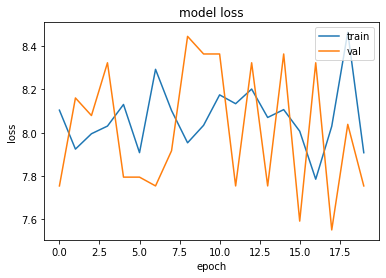

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

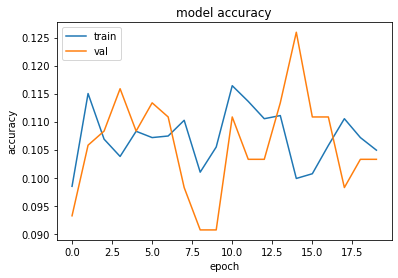

In [ ]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
score, acc = model_Roberta.evaluate(x_test_np, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

# Generate the classification report
y_pred = model_Roberta.predict(x_test_np)
y_pred = y_pred.logits # Extract the logits from the TFSequenceClassifierOutput object
y_pred = tf.nn.softmax(y_pred) # Convert the logits to probabilities
y_pred_class = tf.argmax(y_pred, axis=1) # Get the class index with the highest probability for each sample
print(classification_report(y_test_np, y_pred_class.numpy()))

14/14 [==============================] - 5s 146ms/step - loss: 5.5011 - categorical_accuracy: 0.1111
Test score: 5.501096725463867
Test accuracy: 0.1111111119389534
14/14 [==============================] - 5s 144ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.13      0.66      0.21        59
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00        41
           4       0.08      0.38      0.13        26
           5       0.00      0.00      0.00        47
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        40
           8       0.00      0.00      0.00        42
           9       0.00      0.00      0.00        40

    accuracy                           0.11       441
   macro avg       0.02      0.10      0.03       441
weighted avg       0.02      0.11      0.04       441



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 720x720 with 0 Axes>

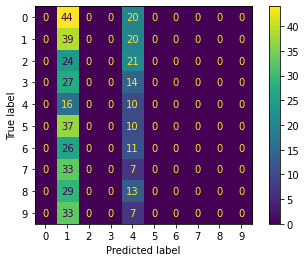

In [ ]:
conf_matrix = confusion_matrix(y_test_np, y_pred_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4,5,6,7,8,9])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

5. Create Q&As pipeline with the best performing model

In [52]:
# train, validation and test split dataset
x_train, x_test, y_train, y_test = train_test_split(data_03["Question"], data_03["Intent"], test_size = 0.1, shuffle=True, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True, random_state = 1)

x_train = x_train.apply(preprocess)
x_val =x_val.apply(preprocess)
x_test = x_test.apply(preprocess)

word_to_counts = Counter(x_train)

# Get the number of unique words in the text data
n_words = len(word_to_counts)

#create a word-to-index dictionary
tokenizer = Tokenizer(num_words=n_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

#convert the text data to numerical data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

#Pad the sequences to have the same length
max_length = max([len(s) for s in x_train_seq + x_val_seq + x_test_seq])
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length)

#Define the number of unique classes
n_classes = len(np.unique(y_train))

# Convert the class labels to one-hot encoded vectors
y_train_enc = tf.keras.utils.to_categorical(y_train, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test, n_classes)

#Model
model_02 = Sequential()
model_02.add(Embedding(input_dim=n_words, output_dim=64, input_length=max_length))
model_02.add(LSTM(64,return_sequences=True))
model_02.add(Dropout(0.5))
model_02.add(LSTM(64, return_sequences=True))
model_02.add(Dropout(0.5))
model_02.add(Flatten())
model_02.add(Dense(n_classes, activation='softmax'))

# Compile and fit the model
model_02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_02.fit(x_train_pad, y_train_enc, batch_size=32, epochs=10, validation_data=(x_val_pad, y_val_enc))


Epoch 1/10
112/112 [==============================] - 4s 13ms/step - loss: 2.2912 - accuracy: 0.1296 - val_loss: 2.2666 - val_accuracy: 0.2317
Epoch 2/10
112/112 [==============================] - 1s 7ms/step - loss: 1.7529 - accuracy: 0.3950 - val_loss: 1.1279 - val_accuracy: 0.6146
Epoch 3/10
112/112 [==============================] - 1s 6ms/step - loss: 0.9183 - accuracy: 0.6926 - val_loss: 0.8356 - val_accuracy: 0.7456
Epoch 4/10
112/112 [==============================] - 1s 6ms/step - loss: 0.5891 - accuracy: 0.8154 - val_loss: 0.6805 - val_accuracy: 0.7834
Epoch 5/10
112/112 [==============================] - 1s 6ms/step - loss: 0.4464 - accuracy: 0.8668 - val_loss: 0.6288 - val_accuracy: 0.8035
Epoch 6/10
112/112 [==============================] - 1s 6ms/step - loss: 0.3338 - accuracy: 0.9013 - val_loss: 0.5980 - val_accuracy: 0.8212
Epoch 7/10
112/112 [==============================] - 1s 6ms/step - loss: 0.2832 - accuracy: 0.9181 - val_loss: 0.6164 - val_accuracy: 0.8060
Epoch

In [53]:
#y_pred = model_02.predict(x_test_pad)
#y_pred = np.argmax(y_pred, axis=1)

In [54]:
#y_pred

In [55]:
import random

# Define the three answers for each intent
intents_answers = {
    0: ["Info about faculty and staff can be found https://aidl.uniwa.gr/instructors/", 'Please check STUDIES>FACULTY & STAFF', 'You may check at FACULTY & STAFF'],
    1: ['Check STUDIES>PROGRAMME OUTLINE', 'Please go to https://aidl.uniwa.gr/programme-outline/', 'Go to the Programme Outline'],
    2: ['Oops, irrelevant question', 'Better google it', "Sorry, can't help"],
    3: ['Check at ADMISSIONS>Applications', 'Please go to https://aidl.uniwa.gr/applications/', 'Please visit ADMISSIONS>Applications form the menu'],
    4: ['Check STUDIES>Course schedule', 'Please visit "Course schedule"', 'This https://aidl.uniwa.gr/course-schedule/ may help you'],
    5: ['Check STUDIES>Documents', 'Please visit https://aidl.uniwa.gr/mscdocuments/', 'Go to STUDIES>Documents'],
    6: ['Go to CONTACT', 'Check CONTACT', 'You may here https://aidl.uniwa.gr/contact/ what you need'],
    7: ['Check at ADMISSIONS>Fees', 'It seems you are looking for https://aidl.uniwa.gr/tuition-fees/', 'Please visit ADMISSIONS>>Fees'],
    8: ['Check https://aidl.uniwa.gr/invited-lecturers-2/', 'Please check STUDIES>FACULTY&STAFF>Invited lecturers', 'Visit STUDIES>FACULTY&STAFF>Invited lecturers'],
    9: ['Go to STUDIES>Students Registry', 'Check STUDIES>Students Registry', 'Look at https://aidl.uniwa.gr/student-registry/']}

    


In [56]:
#Create a function to generate random answers per intent
def generate_answer(intent):
    if intent in intents_answers:
        return random.choice(intents_answers[intent])

In [57]:
#User input
user_input = input("Enter your question: ")

Enter your question: Who teaches deep learning?


In [58]:
input_text = user_input 
input_text = preprocess(input_text)
input_seq = tokenizer.texts_to_sequences([input_text])
input_pad = pad_sequences(input_seq, maxlen=max_length)
prediction = model_02.predict(input_pad)
prediction = np.argmax(prediction)
answer = generate_answer(prediction)
print(answer)

1/1 [==============================] - 1s 578ms/step
Please check STUDIES>FACULTY & STAFF


In [ ]:
#prediction

In [60]:
#input_text = "Which lessons are taught?" 
#input_text = preprocess(input_text)
#input_seq = tokenizer.texts_to_sequences([input_text])
#input_pad = pad_sequences(input_seq, maxlen=max_length)
#prediction = model_02.predict(input_pad)
#prediction = np.argmax(prediction)
#answer = generate_answer(prediction)
#print(answer)

1/1 [==============================] - 0s 17ms/step
Go to the Programme Outline
